In [2]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
import scipy 
import re

H5_FILE = "./DATA/vaspelph.h5"
OUTCAR_FILE = "./DATA/OUTCAR"
WANNIER90_U_MAT_FILE = "./DATA/wannier90_u.mat"
WANNIER90_U_DIS_MAT_FILE = "./DATA/wannier90_u_dis.mat"
POSCAR_FILE = "./DATA/POSCAR"


In [3]:
f = h5py.File(H5_FILE, "r")
matrix = f["matrix_elements"]["elph"][:]
print("matrix, min= ",np.min(matrix)," max=",np.max(matrix))
matrix = matrix[0,...,0] + matrix[0,...,1]*1J
print(matrix.shape)
print("band start kp:", f["matrix_elements"]["band_start_kp"][()])
print("band start k:", f["matrix_elements"]["band_start_k"][()])
band_start_k = f["matrix_elements"]["band_start_k"][()]
band_start_kp = f["matrix_elements"]["band_start_kp"][()]
#crop matrix since wannier has only 48 bands
matrix = matrix[...,:48,:48]
nBand_k = matrix.shape[-2] #I look for the actual one, the one in matrix element
nBand_ph = matrix.shape[2]
nBand_kp = matrix.shape[3]


weights =  f["kpoints"]["wtkpt_k"]
print("weights.shape",weights.shape)
print("unique weights= ",np.unique(weights))

phonon_eigen = np.array(f["matrix_elements"]["phonon_eigenvalues"][:])
print(phonon_eigen.shape)
print("phonon, min= ",np.min(phonon_eigen)," max=",np.max(phonon_eigen))

electron_eigen_FBZ = np.array(f["matrix_elements"]["eigenvalues_kp"][0,:,:]).T
print(electron_eigen_FBZ.shape)

electron_eigen_IBZ = np.array(f["matrix_elements"]["eigenvalues_k"][0,:,band_start_k-1: band_start_k-1+nBand_k]).T
print(electron_eigen_IBZ.shape)

mapFI = np.array(f["kpoints"]["indx_fbz2ibz"][:])



kIBZ = np.array(f["kpoints"]["vkpt_k"][:])
kFBZ = np.array(f["kpoints"]["vkpt_kp"][:])
n_kp = f["matrix_elements"]["nkpts_kp"][()]
n_k = f["matrix_elements"]["nkpts_k"][()]



    

matrix, min=  -1.229800095529188  max= 1.229805647162562
(27, 14, 6, 96, 96)
band start kp: 1
band start k: 1
weights.shape (14,)
unique weights=  [0.03703704 0.07407407]
(27, 14, 6)
phonon, min=  0.0  max= 94.65407107669365
(96, 27)
(48, 14)


In [4]:
#Renormalization function
e = 1.602176634*1e-19
hbar = 1.0545718176461565e-34
kB= 1.380649*1e-23
# try to evaluate band gap renormalization at gamma point within AH approximation, formula 167 review Giustino
def firstOccurance(arr, vec):
    for i in range(len(arr)):
        if(np.all(arr[i]==vec)):
            return i
    return -1


def BE(T,E):
    if(T==0):
       return 0
    c = e/(kB) #Plank divided by Boltzman costant 
    x = E*c/T
    x = np.clip(x, -700, 700)
    return 1/(np.expm1(x))

def FD(T,E,Ef):
    if(T==0.0):
        if(E<=Ef):
            return 1
        else:
            return 0
    c = e/kB
    x = (E - Ef) * c / T
    # Clip to avoid overflow in exp()
    x = np.clip(x, -700, 700)
    return 1.0 / (1.0 + np.exp(x))



def computeRenormalizedBand(matrix,weights,phonon_eigen,electron_eigen_IBZ,electron_eigen_FBZ,kp, n_band,nBand_k, kFBZ,kIBZ,T,Ef, delta = 0.01,nBand_ph=6): #last is same used in vasp by default
    index = firstOccurance(kFBZ,kp)
    dE = 0
    dEv=0
    Enkp = electron_eigen_FBZ[n_band,index]
    for v in range(nBand_ph):
        for i_k in range(len(kIBZ)):
            dEv = 0   
            for m in range(nBand_k):
                g = matrix[index,i_k,v,n_band,m] 
                f = phonon_eigen[index,i_k,v] #THz
                if(f==0): 
                    continue
                Eph = f*hbar*1e12/e # eV
                Emk = electron_eigen_IBZ[m,i_k]
                dEv += np.abs(g)**2*(
                       (1-FD(T,Emk,Ef)+BE(T,Eph))/(Enkp-Emk-Eph+delta*1J)
                    + (FD(T,Emk,Ef)+BE(T,Eph))/(Enkp-Emk+Eph+delta*1J) ).real
                #dEv+= np.abs(g)**2*(1/(Enkp-Emk +delta*1J)).real*(2*BE(T,Eph)+1)
            dEv*=weights[i_k]
            dE += dEv
    
    return  dE

def band_Gap_Renorm(matrix,electron_eigen_IBZ,electron_eigen_FBZ,phonon_eigen,weights,kFBZ,kIBZ,nBand_k=48, PRINT=True):
    with open(OUTCAR_FILE, 'r') as f:
        for line in f:
            match = re.search(r'Fermi energy:\s+([-\d\.Ee]+)', line)
            if match:
                Ef = float(match.group(1))
                break
    n_VB=0
    n_CB=1
    for i in range(nBand_k):
        if(electron_eigen_FBZ[i][0]<=Ef):
            n_VB = i
            n_CB = i+1
        else:
            break


    kp = [0,0,0]
    T = np.arange(0,600,100)
    ks_qp_results = []
    KS = electron_eigen_FBZ[n_CB,0] - electron_eigen_FBZ[n_VB,0]
    if PRINT:
        print("values read from outcar:",n_VB,n_CB,Ef)
        print("Direct gap")
        print("KS eigen=",KS)
        print("     Temperature (K)         RE fan (eV)         QP gap (eV)     KS-QP gap (meV)")
        print("--------------------------------------------------------------------------------")

    for T_val in T:
        dE_VB = computeRenormalizedBand(matrix,weights,phonon_eigen,electron_eigen_IBZ,electron_eigen_FBZ,kp, n_VB,nBand_k,kFBZ,kIBZ, T_val,Ef)
        dE_CB = computeRenormalizedBand(matrix,weights,phonon_eigen,electron_eigen_IBZ,electron_eigen_FBZ,kp, n_CB,nBand_k, kFBZ,kIBZ,T_val,Ef)
        E_CB_renormalized = electron_eigen_FBZ[n_CB,0] + dE_CB
        E_VB_renormalized = electron_eigen_FBZ[n_VB,0] + dE_VB
        qp_direct_gap_at_gamma = E_CB_renormalized - E_VB_renormalized
        
        ks_qp_difference_meV = (KS - qp_direct_gap_at_gamma) * 1000.0
        ks_qp_results.append(ks_qp_difference_meV)
        if PRINT:
            print(f"VB{T_val:16.6f} {dE_VB:18.6f} {qp_direct_gap_at_gamma:18.6f} {ks_qp_difference_meV:18.6f}")
            print(f"CB{0:16.6f} {dE_CB:18.6f} {0:18.6f} {0:18.6f}\n")
    return T,ks_qp_results


band_Gap_Renorm(matrix,electron_eigen_IBZ,electron_eigen_FBZ,phonon_eigen,weights,kFBZ,kIBZ)


values read from outcar: 3 4 5.8093647716
Direct gap
KS eigen= 2.512919979735752
     Temperature (K)         RE fan (eV)         QP gap (eV)     KS-QP gap (meV)
--------------------------------------------------------------------------------
VB        0.000000           0.042788           2.420887          92.032620
CB        0.000000          -0.049245           0.000000           0.000000

VB      100.000000           0.040877           2.421572          91.347777
CB        0.000000          -0.050471           0.000000           0.000000

VB      200.000000           0.030068           2.425308          87.611481
CB        0.000000          -0.057543           0.000000           0.000000

VB      300.000000           0.013627           2.431371          81.548677
CB        0.000000          -0.067922           0.000000           0.000000

VB      400.000000          -0.005136           2.438386          74.534117
CB        0.000000          -0.079671           0.000000           0.

(array([  0, 100, 200, 300, 400, 500]),
 [92.03262041704718,
  91.34777725141063,
  87.61148098694616,
  81.5486765711091,
  74.53411695767275,
  67.8562443574009])

### SVD Reduction over all matrix summing over all phonon and electron bands

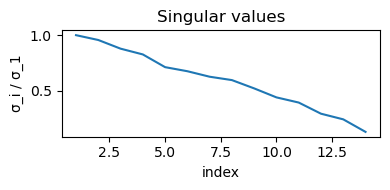

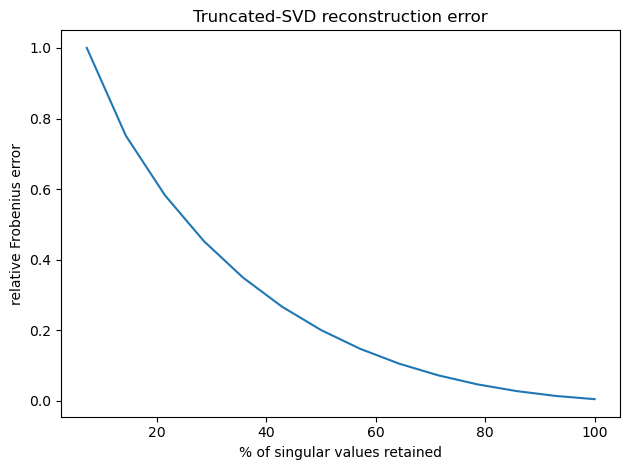

In [5]:
import numpy as np
from scipy.linalg import svdvals, svd

def svd_trend(matrix,nBand_1,nBand_2,nBand_ph ,name=""):
    rmax = min(matrix.shape[0], matrix.shape[1])
    rel_error = np.zeros(rmax, dtype=float)
    frob = 0.0

    for m in range(nBand_1):
        for n in range(nBand_2):
            for v in range(nBand_ph):
                g_kq = matrix[ :, :, v, n, m]
                s = svdvals(g_kq)
                if s.size < rmax:
                    s = np.pad(s, (0, rmax - s.size))
                else:
                    s = s[:rmax]
                s2 = s**2
                frob += s2.sum()
                for k in range(rmax):
                    rel_error[k] += s2[k:].sum()

    rel_error = (rel_error / frob)

    plt.figure(figsize=(4,2))
    plt.plot(np.arange(1, rmax+1), s / s[0])
    plt.xlabel("index")
    plt.ylabel("σ_i / σ_1")
    plt.title(name+"Singular values")
    plt.tight_layout()

    plt.figure()
    x_percent = np.arange(1, rmax + 1) / rmax * 100
    plt.plot(x_percent, rel_error)
    plt.xlabel("% of singular values retained")
    plt.ylabel("relative Frobenius error")
    plt.title(name+"Truncated-SVD reconstruction error")
    plt.tight_layout()
    plt.show()

svd_trend(matrix,nBand_k,nBand_kp,nBand_ph)

### Import transformation matrix $W(\vec{k})$
OUTPUT. Written if write_u_matrices= .TRUE.. The first line gives the date and time at which the
file was created. The second line states the number of kpoints num_kpts and the number of wannier
functions num_wann twice. The third line is empty. Then there are num_kpts blocks of data, each
of which starts with a line containing the kpoint (in fractional coordinates of the reciprocal lattice
vectors) followed by num_wann * num_wann lines containing the matrix elements (real and imaginary
parts) of W(k). The matrix elements are in column-major order (ie, cycling over rows first and then
columns). There is an empty line between each block of data.

In [6]:
W = [] #collection of num_wann*num_wann*2 tensor, one for each k 
with open(WANNIER90_U_MAT_FILE) as f:
    next(f) #skip header
    num_kpts, num_wann, _ = map(int, next(f).split())
    next(f) #skip empty line
        #next(f)
    idW = []
    Kw = np.zeros((num_kpts,3))
    for i in range(num_kpts):
        k = list(map(float,next(f).split()))
        idW.append(int(np.where((np.abs(kFBZ - k) < 1e-8).all(axis=1))[0][0]))
        Kw[idW[-1]] = k
        U_k = np.zeros((num_wann,num_wann),dtype= complex)
        for col in range(num_wann):
            for row in range(num_wann):
               Re,Im = map(float, next(f).split()) 
               U_k[row,col] = Re + Im*1j
        W.append(U_k)
        if(i<num_kpts-1):
            next(f) #skip white line


for i in range(num_kpts):
    if(np.abs(Kw[i]-kFBZ[i]).sum()/3>1e-8):
        print("k", Kw[i], "full:",kFBZ[i])

if(len(idW)!=num_kpts):
    print("ERROR: there is a discrepancy between VASP kPOINTS and WANNIER90")
else:
    idW = np.array(idW)
    W = np.array(W) # follow the same indexing of kPoint of vasp output!
    W = W[idW]
    print(W.shape)

W_dag = W.conjugate().transpose(0,2,1)





(27, 8, 8)


### Import Disentanglement transformation matrix $W(\vec{k}_p)_{dis}$
OUTPUT. Written if write_u_matrices= .TRUE. and disentanglement is enabled. The first line
gives the date and time at which the file was created. The second line states the number of kpoints
num_kpts, the number of wannier functions num_wan and the number of num_bands. The third line
is empty. Then there are num_kpts blocks of data, each of which starts with a line containing the
kpoint (in fractional coordinates of the reciprocal lattice vectors) followed by num_wann * num_bands
lines containing the matrix elements (real and imaginary parts) of Udis(k). The matrix elements are
in column-major order (ie, cycling over rows first and then columns). There is an empty line between
each block of data.

In [7]:
W_dis = [] #collection of num_wann*num_wann*2 tensor, one for each k 
with open(WANNIER90_U_DIS_MAT_FILE) as f:
    next(f) #skip header
    #map apply to each element of the splitted string the int operator
    num_kpts, num_wann, num_bands = map(int, next(f).split())
    Kw = np.zeros((num_kpts,3))
    next(f) #skip empty line
        #next(f)
    idW = [] 
    for i in range(num_kpts):
        k = list(map(float,next(f).split()))
        idW.append(int(np.where((np.abs(kFBZ - k) < 1e-8).all(axis=1))[0][0]))
        Kw[idW[-1]] = k
        U_k = np.zeros((num_bands, num_wann), dtype=complex)
        for col in range(num_wann):          # columns
            for row in range(num_bands):     # rows
                Re, Im = map(float, next(f).split())
                U_k[row, col] = Re + 1j * Im

        W_dis.append(U_k)
        if(i<num_kpts-1):
            next(f) #skip white line

for i in range(num_kpts):
    if(np.abs(Kw[i]-kFBZ[i]).sum()/3>1e-4):
        print("Uncorrespondence k:", Kw[i], "full:",kFBZ[i])

if(len(idW)!=num_kpts):
    print("ERROR: there is a discrepancy between VASP kPOINTS and WANNIER90")
else:
    idW = np.array(idW)
    W_dis = np.array(W_dis) # follow the same indexing of kPoint of vasp output!
    W_dis = W_dis[idW]
    print(W_dis.shape)



(27, 48, 8)


### CREATE A LATTICE MESH

$AB^T = \begin{bmatrix}\vec{a}_1 \\\vec{a}_2 \\\vec{a}_3 \end{bmatrix} \begin{bmatrix}\vec{b}_1^T \vec{b}_2^T \vec{b}_3^T \end{bmatrix} = 2\pi$ unit matrix 

In [8]:
with open(POSCAR_FILE) as f:
    next(f) #skip title
    a = float(next(f)) 
    A = []
    vector = next(f).split()
    while(len(vector)==3):
        A.append(list(map(float,vector)))
        vector = next(f).split()
    A = a*np.array(A)

Kmesh = 3
shift = Kmesh//2
M = np.array([([m1,m2,m3]) 
              for m1 in range(-shift,Kmesh-shift) 
              for m2 in range(-shift,Kmesh-shift)
                for m3 in range(-shift,Kmesh-shift)])
R = M @ A 

print("Min R:", R.min(axis=0))
print("Max R:", R.max(axis=0))
print(R.shape[0])

B = np.zeros(A.shape)

B[0] = 2*np.pi*np.cross(A[1],A[2])/(A[0].dot(np.cross(A[1],A[2])))
B[1] = 2*np.pi*np.cross(A[2],A[0])/(A[0].dot(np.cross(A[1],A[2])))
B[2] = 2*np.pi*np.cross(A[0],A[1])/(A[0].dot(np.cross(A[1],A[2])))

print(A @ B.T)


K = kFBZ @ B

print(K.shape)





Min R: [-5.468 -5.468 -5.468]
Max R: [5.468 5.468 5.468]
27
[[ 6.28318531e+00  1.58197609e-16 -1.58197609e-16]
 [ 1.58197609e-16  6.28318531e+00 -1.58197609e-16]
 [ 1.58197609e-16 -1.58197609e-16  6.28318531e+00]]
(27, 3)


### full matrix $A$ with disentanglement


In [9]:
A = np.array([ W_dis[i] @ W[i] for i in range(W.shape[0])])
print(A.shape)

A1 = np.einsum("kmj,kji->kmi",W_dis,W)
print(A1.shape)

np.allclose(A1, A)

A_dag = np.conjugate(A).transpose(0,2,1)
print(A_dag.shape)
print("W_dag:", A_dag.shape)
print("W:", A.shape)

"""for i in range(n_kp):
    print(np.allclose(W[i] @ W_dag[i],np.eye(W[0].shape[0])))"""


(27, 48, 8)
(27, 48, 8)
(27, 8, 48)
W_dag: (27, 8, 48)
W: (27, 48, 8)


'for i in range(n_kp):\n    print(np.allclose(W[i] @ W_dag[i],np.eye(W[0].shape[0])))'

### Extend Matrix
When ISYM=0 the only reduction of kpoints regards -k <-> k simmetry: $\Psi(-\vec{k}) = \Psi(\vec{k})^*$
and in this case $g(-\vec{k},-\vec{k}_p) = g(\vec{k},\vec{k}_p)^*\\$
For point with this simmetry the codification is such that if at position i there is $\vec{k}$ at i+1 there is $-\vec{k}$
This means that for each i_k its worth it to check i_k+1 , in that case one can use this info to extend the matrix

In [10]:
import gc

def InverseExist(kFBZ,kIBZ,n_k,n_kp,weights, mapFI):
    Exist = np.zeros(n_k,dtype=bool)
    print(Exist)
    weights_ext = np.zeros(n_kp,dtype=float)
    i = 0
    while(i<n_kp-1):
        if(np.allclose(kFBZ[i],-kFBZ[i+1])):
            Exist[mapFI[i]-1] = True
            # The original weight for summation is now divided by two for eanch one
            #print(i,i+1,"split", weights[mapFI[i]-1])
            weights_ext[i] = weights_ext[i+1] = weights[mapFI[i]-1]/2
            i+=2
        else:
            Exist[mapFI[i]-1] = False #arleady false actually 
            #print(i,"retain", weights[mapFI[i]-1])
            weights_ext[i] = weights[mapFI[i]-1] #keep the original weight
            i+=1
    return Exist,weights_ext
            


def extend_matrix(matrix, kFBZ, kIBZ, n_k, n_kp, mapFI,weights):
    """
    Extend g(kp,k) from FBZ×IBZ -> FBZ×FBZ using inversion symmetry.
    Assumes consecutive FBZ points are (k,-k).
    """

    # allocate extended array: FBZ×FBZ
    new_shape = (n_kp, n_kp) + matrix.shape[2:]
    matrix_ext = np.zeros(new_shape, dtype=matrix.dtype)
    exist,weights_ext = InverseExist(kFBZ, kIBZ, n_k, n_kp, weights, mapFI)
    phonon_eigen_ext = np.zeros((n_kp,n_kp,nBand_ph))

    # extended electronic k-point list
    k_ext = np.zeros_like(kFBZ)

    i_kext = 0
    i_k = 0
    while i_kext < n_kp and i_k < n_k:
        # copy direct k
        matrix_ext[:, i_kext] = matrix[:, i_k]
        phonon_eigen_ext[:,i_kext,:]=phonon_eigen[:,i_k,:]
        k_ext[i_kext] = kIBZ[i_k]
        i_kext += 1

        if exist[i_k]:
            # generate -k partner
            k_ext[i_kext] = -kIBZ[i_k]
            i_kp = 0
            while i_kp < n_kp - 1:
                if exist[mapFI[i_kp] - 1]:
                    # conjugate-fill symmetric pair
                    matrix_ext[i_kp, i_kext]   = np.conjugate(matrix[i_kp + 1, i_k])
                    matrix_ext[i_kp + 1, i_kext] = np.conjugate(matrix[i_kp, i_k])
                    phonon_eigen_ext[i_kp,i_kext,:]=phonon_eigen[i_kp+1,i_k,:]
                    phonon_eigen_ext[i_kp+1,i_kext,:]=phonon_eigen[i_kp,i_k,:]
                    i_kp += 2
                else:
                    matrix_ext[i_kp, i_kext] = matrix[i_kp, i_k]
                    phonon_eigen_ext[i_kp,i_kext,:]=phonon_eigen[i_kp,i_k,:]
                    i_kp += 1
            i_kext += 1
        i_k += 1

    print("matrix_ext.shape =", matrix_ext.shape)
    print("sanity check of correspondence:",
          np.allclose(k_ext, kFBZ, atol=1e-8))
    del matrix
    gc.collect()

    return matrix_ext, weights_ext,phonon_eigen_ext

    

print(matrix.shape)
print("extend")


matrix_ext,weights_ext,phonon_eigen_ext = extend_matrix(matrix,kFBZ,kIBZ,n_k,n_kp,mapFI,weights)
print("phonon", phonon_eigen_ext.shape, phonon_eigen.shape)
pairs = sum(np.allclose(kFBZ[i], -kFBZ[i+1]) for i in range(1, n_kp-1, 2))
print(f"{pairs} of {n_kp//2} pairs are (k,-k)")
print((np.sum(weights_ext)-np.sum(weights))<1e-8) #check  weight conservation, sum almost 1

band_Gap_Renorm(matrix_ext,electron_eigen_FBZ,electron_eigen_FBZ,phonon_eigen_ext,weights_ext,kFBZ,kFBZ)

(27, 14, 6, 48, 48)
extend
[False False False False False False False False False False False False
 False False]
matrix_ext.shape = (27, 27, 6, 48, 48)
sanity check of correspondence: True
phonon (27, 27, 6) (27, 14, 6)
13 of 13 pairs are (k,-k)
True
values read from outcar: 3 4 5.8093647716
Direct gap
KS eigen= 2.512919979735752
     Temperature (K)         RE fan (eV)         QP gap (eV)     KS-QP gap (meV)
--------------------------------------------------------------------------------
VB        0.000000           0.042788           2.420887          92.032620
CB        0.000000          -0.049245           0.000000           0.000000

VB      100.000000           0.040877           2.421572          91.347777
CB        0.000000          -0.050471           0.000000           0.000000

VB      200.000000           0.030068           2.425308          87.611481
CB        0.000000          -0.057543           0.000000           0.000000

VB      300.000000           0.013627         

(array([  0, 100, 200, 300, 400, 500]),
 [92.03262041704718,
  91.34777725141063,
  87.61148098694616,
  81.5486765711091,
  74.53411695767275,
  67.8562443574009])

### Wannier Transformation

$g_{ij}(\vec{R_e},\vec{R_p})=\frac{1}{N_k}\sum_{mn\vec{k}_p}\sum_{\vec{q}} e^{-i(\vec{k}_p\vec{R_e} + \vec{q}\vec{R_p})} U^{\dag}_{im}(\vec{k}_p+\vec{q})g_{mn}({\vec{k}_p+\vec{q},\vec{q}})U_{nj}(\vec{k}_p)$

with: $\vec{k} = \vec{q} + \vec{k_p}$ becomes:

$g_{ij}(\vec{R_e},\vec{R_p})=\frac{1}{N_k}\sum_{mn\vec{k}_p}\sum_{\vec{k}} e^{-i(\vec{k}_p\vec{R_e} + (\vec{k}-\vec{k}_p)\vec{R_p})} U^{\dag}_{im}(\vec{k})g_{mn}({\vec{k},\vec{k_p}})U_{nj}(\vec{k}_p)$

Define, than can be computed once for ever, loading m and n slices times by times allow to reduce memory consumption over calculation speed:

$G_{\nu ij}(\vec{k},\vec{k_p}) = \sum_{mn}U^{\dag}_{im}(\vec{k})g_{\nu mn}({\vec{k},\vec{k_p}})U_{nj}(\vec{k}_p)$

Recal: g shape: { n_kp, n_k, 3*natoms, nBand_kp, nBand_k}

In such a way:

$g_{\nu ij}(\vec{R_e},\vec{R_p})=\frac{1}{N_k^2}\sum_{\vec{k}_p}\sum_{\vec{k}}e^{-i(\vec{k}_p\vec{R_e} + (\vec{k}-\vec{k}_p)\vec{R_p})} G_{ij}(\vec{k},\vec{k_p})$

In [11]:
def save_G_to_h5(G,kFBZ, filename="G.h5",):
    """
    Write complex Wannier-transformed g (G) to HDF5 file.
    """
    with h5py.File(filename, "w") as f:
        f.create_dataset("G", data=G, dtype=np.complex128)
        f.create_dataset("kpoints", data=kFBZ, dtype=float)
        f.create_dataset("nkpts", data=kFBZ.shape[0], dtype=int)

matrix_no = matrix_ext[...,:8,:8]
G_no = np.einsum('kim,wkvnm,wnj->wkvij', W_dag, matrix_no, W) 

matrix_no_new = np.einsum('kmi,wkvij,wjn->wkvnm', W, G_no, W_dag) 

print("Verify first Transformation: ",np.allclose(matrix_no_new,matrix_no))


Verify first Transformation:  True


In [12]:
# build phase matrices
exp_k   = np.exp(-1j * (K @ R.T))    # (n_kp, n_Rp)

# perform double sum with correct phase factors
g_wannier_no = np.einsum(
    'wS, kR, wR, wkvij -> SRvij',
    exp_k,         # factor 1: e^{-i k_k·R_Rp}
    exp_k,         # factor 2: e^{-i k_kp·R_Re}
    np.conjugate(exp_k),        # factor 3: e^{+i k_kp·R_Rp}
    G_no,                # G_{vij}(k_k, k_kp)
    optimize=True
)

g_wannier_no /= (num_kpts**2)

In [13]:
def Antitransform(g_wannier,K,R,W,W_dag):
  exp_k = np.exp(1j*(K @ R.T))
  return np.einsum('wR,kS,wS,kmi,RSvij,wjn->wkvnm', 
                  exp_k,
                  exp_k,
                  np.conjugate(exp_k),
                  W, 
                  g_wannier,
                  W_dag, 
                    optimize=True)

g_new_no = Antitransform(g_wannier_no,K,R,W,W_dag)
print("Verify second Transformation: ",np.allclose(g_new_no,matrix_no,rtol=1e-1))

band_Gap_Renorm(g_new_no,electron_eigen_FBZ,electron_eigen_FBZ,phonon_eigen_ext,weights_ext,kFBZ,kFBZ,nBand_k=8)
#svd_trend(g_wannier_no,8,8,6)

Verify second Transformation:  True
values read from outcar: 3 4 5.8093647716
Direct gap
KS eigen= 2.512919979735752
     Temperature (K)         RE fan (eV)         QP gap (eV)     KS-QP gap (meV)
--------------------------------------------------------------------------------
VB        0.000000           0.079249           2.425661          87.258825
CB        0.000000          -0.008010           0.000000           0.000000

VB      100.000000           0.078620           2.426721          86.198930
CB        0.000000          -0.007579           0.000000           0.000000

VB      200.000000           0.076047           2.432383          80.536790
CB        0.000000          -0.004490           0.000000           0.000000

VB      300.000000           0.072053           2.440976          71.944054
CB        0.000000           0.000109           0.000000           0.000000

VB      400.000000           0.067474           2.450713          62.206711
CB        0.000000           0.00

(array([  0, 100, 200, 300, 400, 500]),
 [87.25882536825935,
  86.19893007496415,
  80.5367895389848,
  71.94405404843974,
  62.20671087177276,
  52.724146809958405])

### MATRIX 
$g(\vec{R}_e,\vec{R}_p)_{vnm} = \sum_{r=1}^{r_{max}} \vec{u}(\vec{R}_e)_{vnm}\,\sigma_{rvnm}\,\vec{v}^{\top}(\vec{R}_p)_{vnm}$

$g_{v,n,m} = \sum_{r=1}^{r_{max}} \sigma_{r v n m}\; U_{:,r,v,n,m}\; V_{:,r,v,n,m}^{\top}$


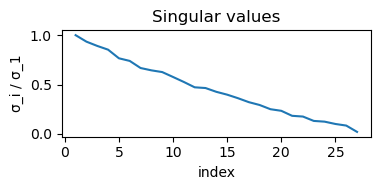

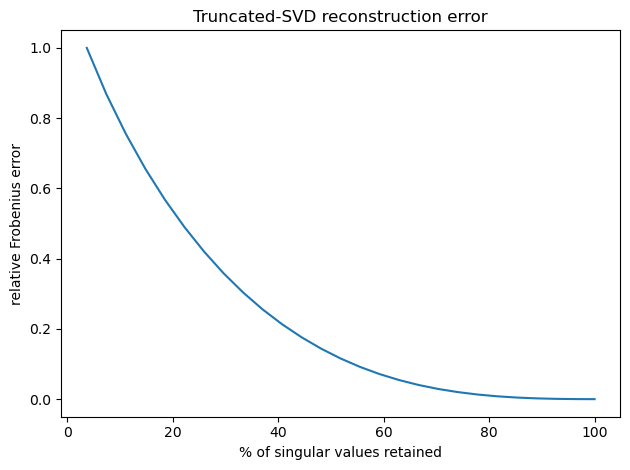

values read from outcar: 3 4 5.8093647716
Direct gap
KS eigen= 2.512919979735752
     Temperature (K)         RE fan (eV)         QP gap (eV)     KS-QP gap (meV)
--------------------------------------------------------------------------------
VB        0.000000           0.079249           2.425661          87.258825
CB        0.000000          -0.008010           0.000000           0.000000

VB      100.000000           0.078620           2.426721          86.198930
CB        0.000000          -0.007579           0.000000           0.000000

VB      200.000000           0.076047           2.432383          80.536790
CB        0.000000          -0.004490           0.000000           0.000000

VB      300.000000           0.072053           2.440976          71.944054
CB        0.000000           0.000109           0.000000           0.000000

VB      400.000000           0.067474           2.450713          62.206711
CB        0.000000           0.005267           0.000000           0.

(array([  0, 100, 200, 300, 400, 500]),
 [87.25882536825935,
  86.19893007496415,
  80.5367895389848,
  71.94405404843974,
  62.20671087177276,
  52.724146809958405])

In [14]:
def SVD(matrix,nBand_n,nBand_m,nBand_ph ,name="",SVlist = np.empty(0), PLOT=True):
    rmax = min(matrix.shape[0], matrix.shape[1])
    U = np.zeros((matrix.shape[0],rmax,nBand_ph,nBand_n,nBand_m),dtype="complex")
    Vt = np.zeros((rmax,matrix.shape[1],nBand_ph,nBand_n,nBand_m) ,dtype="complex")
    s = np.zeros((rmax,nBand_ph,nBand_n,nBand_m),dtype="complex")

    for m in range(nBand_m):
        for n in range(nBand_n):
            for v in range(nBand_ph):
                U[...,v,n,m],s[...,v,n,m],Vt[...,v,n,m] = svd(matrix[...,v,n,m],full_matrices=False)

    if PLOT:
        pad = [(0,0)]*s.ndim
        results = np.zeros(rmax)
        norm = np.sum(np.abs(matrix)**2)
        gi = np.zeros(matrix.shape)
        for i in range(rmax):
            pad[0] = (0,rmax - i -1 )
            s_red = np.pad(s[:i+1], pad)
            #print(s_red[...,2,3,4])
            gi = np.einsum("rvnm,irvnm,rkvnm -> ikvnm",s_red,U,Vt)
            results[i] =  np.sum(np.abs(matrix-gi)**2)/norm
        
        plt.figure()
        plt.plot(np.arange(rmax)/rmax*100, results)
    
    return U,s,Vt


def getLowRank(U,s,Vt,rank):
    if(rank>s.shape[0]):
        print("non valid rank")
        return
    pad = [(0,0)]*s.ndim
    rmax = s.shape[0]
    pad[0] = (0,rmax - rank )
    s_red = np.pad(s[:rank], pad)
    return  np.einsum("rvnm,irvnm,rkvnm -> ikvnm",s_red,U,Vt)
    


svd_trend(g_wannier_no,8,8,6)
U,s,Vt = SVD(g_wannier_no,8,8,nBand_ph,PLOT=False)
gi = getLowRank(U,s,Vt,27)

g_ki = Antitransform(gi,K,R,W,W_dag)
band_Gap_Renorm(g_ki,electron_eigen_FBZ,electron_eigen_FBZ,phonon_eigen_ext,weights_ext,kFBZ,kFBZ,nBand_k=8)



### Antitransform Truncated Matrix

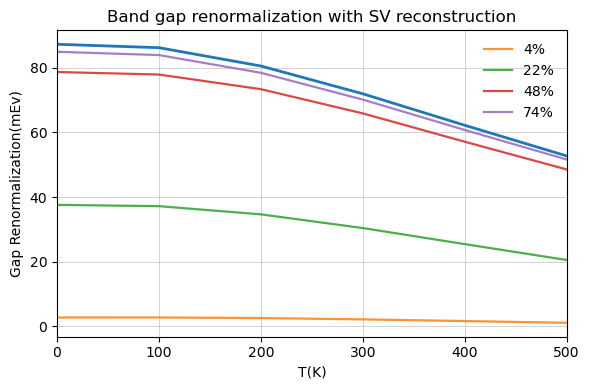

In [15]:
perc = [5, 25, 50, 75]
rmax = s.shape[0]
ranks = [int(p/100 * rmax) for p in perc]
T, renorm0 = band_Gap_Renorm(
    g_new_no, electron_eigen_FBZ, electron_eigen_FBZ,
    phonon_eigen_ext, weights_ext, kFBZ, kFBZ, nBand_k=8, PRINT=False
)

plt.figure(figsize=(6,4))
plt.plot(T, renorm0, linewidth=2)

for rank in ranks:
    gr = getLowRank(U, s, Vt, rank)
    gk = Antitransform(gr, K, R, W, W_dag)
    _, renorm = band_Gap_Renorm(
        gk, electron_eigen_FBZ, electron_eigen_FBZ,
        phonon_eigen_ext, weights_ext, kFBZ, kFBZ, nBand_k=8, PRINT=False
    )
    pct = 100 * rank / s.shape[0]
    plt.plot(T, renorm, linewidth=1.6, alpha=0.85, label=f"{pct:.0f}%")

plt.grid(True, linewidth=0.4)
plt.xlabel("T(K)")
plt.ylabel("Gap Renormalization(mEv)")
plt.title("Band gap renormalization with SV reconstruction")
plt.xlim(np.min(T), np.max(T))
plt.tight_layout()
plt.legend(frameon=False)
plt.show()